In [26]:
import pandas as pd
import numpy as np

from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_encoded.csv')
df.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Windows,Mac,...,gen_casual,gen_simulation,gen_strategy,gen_action,gen_adventure,gen_sports,gen_racing,gen_massivelymultiplayer,dev_te,pub_te
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,1,0,...,0,0,0,0,0,0,0,0,75.929477,64.206827
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,1,1,...,1,1,1,0,0,0,0,0,75.691655,75.691655
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,1,0,...,1,0,1,1,1,0,0,0,75.691655,75.691655
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,1,0,...,0,1,1,0,1,0,0,0,75.660419,70.750349
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,1,1,...,0,1,0,1,1,0,0,0,75.244586,75.244586


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   itad_id                   30947 non-null  object 
 1   appid                     30947 non-null  float64
 2   title                     30947 non-null  object 
 3   release_date              30947 non-null  object 
 4   early_access              30947 non-null  int64  
 5   mature                    30947 non-null  int64  
 6   launch_price              30947 non-null  float64
 7   days_to_first_sale        30947 non-null  int64  
 8   Windows                   30947 non-null  int64  
 9   Mac                       30947 non-null  int64  
 10  Linux                     30947 non-null  int64  
 11  Achievements              30947 non-null  int64  
 12  Developers                30947 non-null  object 
 13  Publishers                30947 non-null  object 
 14  Catego

In [29]:
df1 = df[['gen_indie', 'gen_action', 'gen_adventure', 'gen_casual', 'gen_rpg', 'gen_strategy', 'gen_simulation', 'gen_massivelymultiplayer', 'gen_sports', 'gen_racing']]
df1.head()

,gen_indie,gen_action,gen_adventure,gen_casual,gen_rpg,gen_strategy,gen_simulation,gen_massivelymultiplayer,gen_sports,gen_racing
0,1,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,1,1,0,0,0
2,1,1,1,1,0,1,0,0,0,0
3,1,0,1,0,1,1,1,0,0,0
4,1,1,1,0,0,0,1,0,0,0


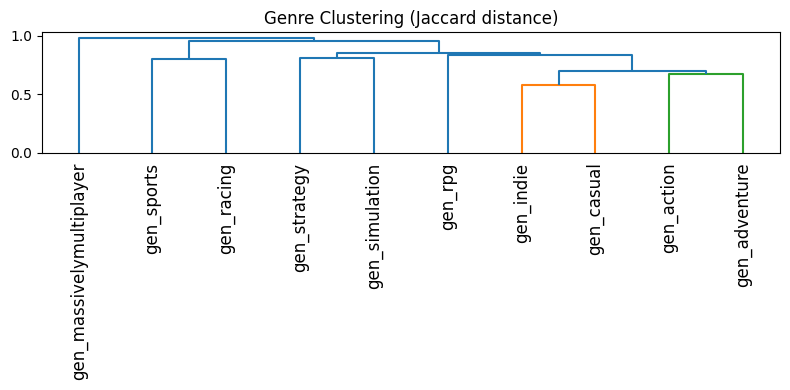

                      genre  cluster
8                gen_sports        1
9                gen_racing        1
5              gen_strategy        2
6            gen_simulation        2
0                 gen_indie        3
1                gen_action        3
2             gen_adventure        3
3                gen_casual        3
4                   gen_rpg        3
7  gen_massivelymultiplayer        4


In [30]:
# 1) pick genre columns and ensure boolean
genre_cols = [
    'gen_indie','gen_action','gen_adventure','gen_casual','gen_rpg',
    'gen_strategy','gen_simulation','gen_massivelymultiplayer','gen_sports','gen_racing'
]
G = df[genre_cols].astype(bool)

# 2) make "genres as rows" boolean matrix
#    shape: (n_genres, n_games)
X = G.to_numpy(dtype=bool).T

# 3) pairwise Jaccard distances BETWEEN GENRES (condensed vector)
condensed = pdist(X, metric='jaccard')   # works on boolean NumPy array

# 4) hierarchical clustering on condensed distances
Z = linkage(condensed, method='average')

# 5) (optional) visualize dendrogram
plt.figure(figsize=(8, 4))
dendrogram(Z, labels=genre_cols, leaf_rotation=90)
plt.title("Genre Clustering (Jaccard distance)")
plt.tight_layout()
plt.show()

# 6) cut into K clusters and map genres → cluster id
K = 4
genre_cluster_ids = fcluster(Z, K, criterion='maxclust')   # labels 1..K in same order as genre_cols
genre_to_cluster = dict(zip(genre_cols, genre_cluster_ids))

# 7) per-game cluster features (multi-hot over clusters)
for c in range(1, K+1):
    cols_in_c = [g for g, cid in genre_to_cluster.items() if cid == c]
    df[f'genre_cluster_{c}'] = (df[cols_in_c].sum(axis=1) > 0).astype(int)

# (optional) inspect cluster composition
cluster_summary = (
    pd.Series(genre_to_cluster, name='cluster')
      .to_frame()
      .reset_index()
      .rename(columns={'index':'genre'})
      .sort_values('cluster')
)
print(cluster_summary)

In [31]:
# mapping you just got (adjust if your IDs differ)
genre_to_cluster = {
    'gen_sports': 1, 'gen_racing': 1,
    'gen_strategy': 2, 'gen_simulation': 2,
    'gen_indie': 3, 'gen_action': 3, 'gen_adventure': 3, 'gen_casual': 3, 'gen_rpg': 3,
    'gen_massivelymultiplayer': 4
}

# create per-game cluster flags
K = max(genre_to_cluster.values())
for c in range(1, K+1):
    cols_in_c = [g for g, cid in genre_to_cluster.items() if cid == c]
    df[f'genre_cluster_{c}'] = (df[cols_in_c].sum(axis=1) > 0).astype(int)

# (optional) readable names
cluster_names = {
    1: "genre_cluster_sports_competitive",
    2: "genre_cluster_strategy_sim",
    3: "genre_cluster_story_action_mainstream",
    4: "genre_cluster_mmo",
}
df = df.rename(columns={f'genre_cluster_{k}': v for k, v in cluster_names.items()})

# drop original genre columns now that clusters exist
df = df.drop(columns=list(genre_to_cluster.keys()))

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   itad_id                                30947 non-null  object 
 1   appid                                  30947 non-null  float64
 2   title                                  30947 non-null  object 
 3   release_date                           30947 non-null  object 
 4   early_access                           30947 non-null  int64  
 5   mature                                 30947 non-null  int64  
 6   launch_price                           30947 non-null  float64
 7   days_to_first_sale                     30947 non-null  int64  
 8   Windows                                30947 non-null  int64  
 9   Mac                                    30947 non-null  int64  
 10  Linux                                  30947 non-null  int64  
 11  Ac

In [33]:
df.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Windows,Mac,...,publisher_game_count,cat_singleplayer,cat_familysharing,cat_other,dev_te,pub_te,genre_cluster_sports_competitive,genre_cluster_strategy_sim,genre_cluster_story_action_mainstream,genre_cluster_mmo
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,1,0,...,95,1,1,1,75.929477,64.206827,0,0,1,0
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,1,1,...,1,1,1,1,75.691655,75.691655,0,1,1,0
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,1,0,...,1,1,1,1,75.691655,75.691655,0,1,1,0
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,1,0,...,12,1,1,0,75.660419,70.750349,0,1,1,0
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,1,1,...,2,1,1,1,75.244586,75.244586,0,1,1,0


In [34]:
# saving clustered genre data

df.to_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_genre_clusters.csv', index=False)